In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import SpectralEmbedding
from sklearn.metrics import r2_score

import sys
sys.path.append(sys.path[0][:-37])

import imp

from ikd import utils, core, evaluate, datasets, epca
imp.reload(utils)
imp.reload(core)
imp.reload(evaluate)
imp.reload(datasets)
imp.reload(epca)

<module 'ikd.epca' from 'd:\\GT\\Lab\\ikd NeurIPS 2022\\src\\ikd\\epca.py'>

Text(0.5, 1.0, 'cov_true')

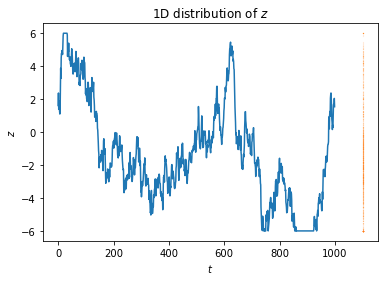

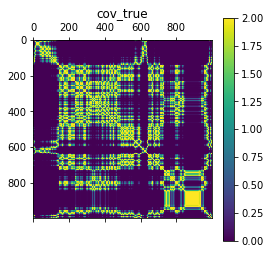

In [9]:
z_true = datasets.generate_latent(1, 1, show=True)
n_points, d_latent = z_true.shape
kernel = "squared exponential"
variance = 2
length_scale = 1
plt.plot(1100 * np.ones(n_points), z_true[:, 0], '.', markersize=0.1)
plt.title("1D distribution of $z$")
# plt.savefig("test.pdf")

cov_true = utils.kernel_cov_generator(z_true, kernel=kernel, variance=variance, length_scale=length_scale)
plt.matshow(cov_true)
plt.colorbar()
plt.title("cov_true")

Too many remaining indices, use nearest neighbors to find all cliques for every points
Clique threshold: 0.2797940008672037, number of cliques: 1000
200 observation dimensionality, trial 8


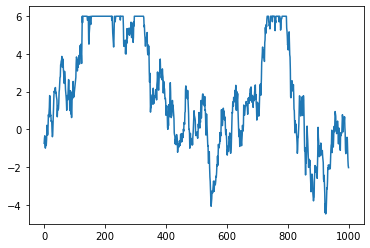

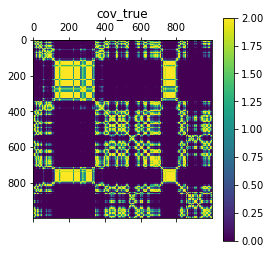

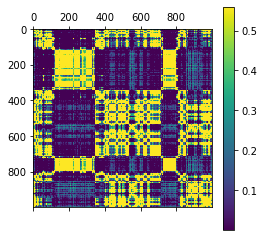

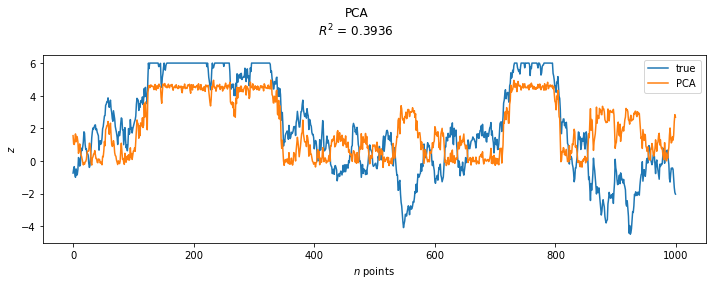

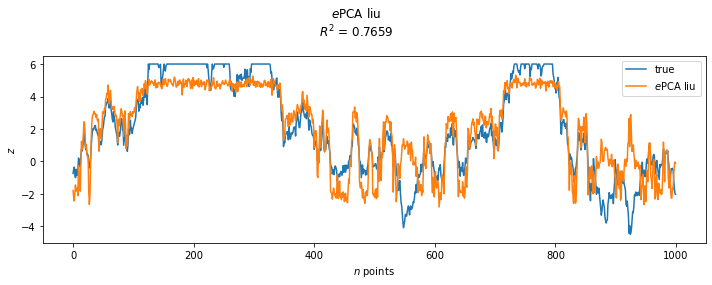

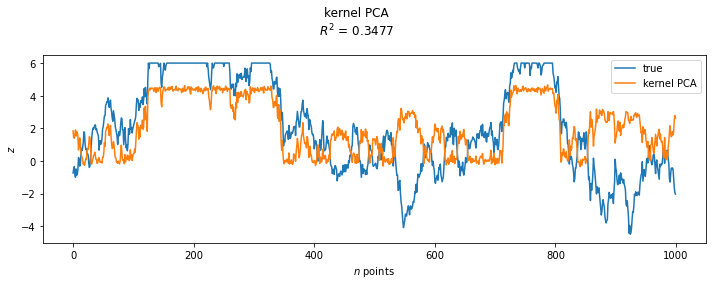

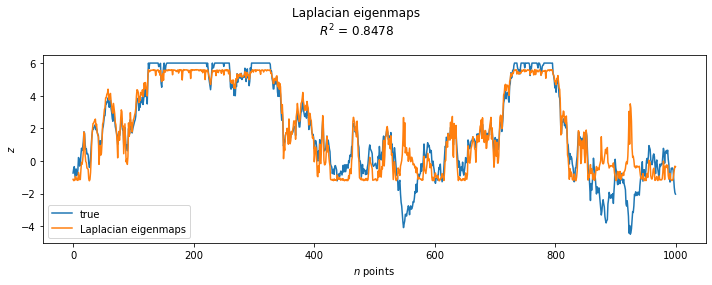

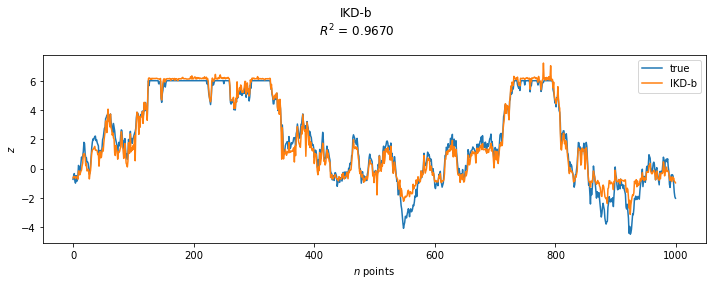

In [12]:
trial = 8

z_true = datasets.generate_latent_from_prior(1, 1000, kernel='autoregressive', variance=9, length_scale=100, bound=6, seed=trial)
plt.plot(z_true[:, 0])
cov_true = utils.kernel_cov_generator(z_true, kernel=kernel, variance=variance, length_scale=length_scale)
plt.matshow(cov_true)
plt.colorbar()
plt.title("cov_true")

d_observation = 200
backward = "sqrt"
rng = np.random.default_rng(trial)
x = rng.multivariate_normal(mean=np.zeros(n_points), cov=cov_true, size=d_observation).T
firing_rates = np.exp(x)
spikes = rng.poisson(firing_rates).astype(float)

spikes_dense = utils.backward(spikes, method=backward)
cov_spikes = np.cov(spikes_dense)
# variance_spikes = np.min(np.diag(cov_spikes))
variance_spikes = np.mean(cov_spikes) * 2
cov_spikes_th = utils.filt_cov_samp(cov_spikes, variance_spikes)

plt.matshow(cov_spikes_th)
plt.colorbar()

z_pca = PCA(n_components=d_latent).fit_transform(spikes_dense) # pca
# z_epca_collin = epca.poisson_pca(spikes, n_components=d)[0] # epca collin
z_epca_liu = epca.exp_fam_pca(spikes, "poisson", r=d_latent)[3] # epca liu
evaluate.compare_latents(z_true, utils.align(z_true, z_pca), "PCA")
# evaluate.compare_latents(z_true, utils.align(z_true, z_epca_collin), "epca collin")
evaluate.compare_latents(z_true, utils.align(z_true, z_epca_liu), "$e$PCA liu")

z_kernel_pca = KernelPCA(n_components=d_latent, kernel='cosine').fit_transform(spikes_dense)
evaluate.compare_latents(z_true, utils.align(z_true, z_kernel_pca), "kernel PCA")

z_le = SpectralEmbedding(n_components=d_latent).fit_transform(spikes_dense)
evaluate.compare_latents(z_true, utils.align(z_true, z_le), "Laplacian eigenmaps")

# z_full = core.ikd(cov_spikes_th, d, kernel=kernel, variance=variance_spikes, length_scale=1)[0]
z_ikd = core.ikd_blockwise(cov_spikes_th, d_latent, kernel=kernel, variance=variance_spikes, length_scale=1, clique_th_or_d_observation=d_observation, z_ref=z_le)
evaluate.compare_latents(z_true, utils.align(z_true, z_ikd), "IKD-b")

# sol = epca.exp_fam_pca(spikes.T, "poisson", r=d_observation)
# firing_rates_est = epca.wiener_filter(sol[0], spikes.T, "poisson").T
# firing_rates_est[firing_rates_est < 0] = 0

# x_est = utils.backward(firing_rates_est, method=backward)
# cov_est = np.cov(x_est)

# # variance_est = np.min(np.diag(cov_est))
# variance_est = 2 * np.mean(cov_est)
# cov_est_th = utils.filt_cov_samp(cov_est, variance_est)
# plt.matshow(cov_est_th)
# plt.colorbar()
# z_full_denoised = core.ikd(cov_est_th, d_latent, kernel=kernel, variance=variance_est, length_scale=1)[0]
# z_block_denoised = core.ikd_blockwise(cov_est_th, d_latent, kernel=kernel, variance=variance_est, length_scale=1, clique_th_or_d_observation=d_observation)
# evaluate.compare_latents(z_true, utils.align(z_true, z_block_denoised), "$e$IKD-b")
print(f"{d_observation} observation dimensionality, trial {trial}")